# ANALISIS DE RESULTADOS

## globales

In [406]:
file_path = '../outputs/table_outputs/jetson_orin_agx/orin_agx_dynamic_op.md'
name = 'jetson_orin_agx'
name_titulo = 'Jetson Orin AGX'

## funciones

In [407]:
def generate_latex_table(data):


    # genera la tabla presente en los antecedentes de la tesis


    latex_header_1 = r"""
\begin{table}[t]
    \centering
    \footnotesize
    \caption{"""
    latex_header_2 = r"""}
    \begin{tabular}{@{}clccccccccccc@{}}
    \toprule
    & & \multicolumn{2}{c}{Latency {[}ms{]}} &  & Thr. {[}inf/s{]} &  \multicolumn{3}{c}{Model properties} &  & \multicolumn{2}{c}{Accuracy [\%]} \\ \cmidrule(lr){3-4}  \cmidrule(lr){7-9} \cmidrule(l){11-12} 
    & & ave.              & max.             &  &                       &  Size {[}MB{]}   & \# Layers   & \# Weights   &  & Top 1       & Top 5      \\ \midrule"""
    latex_footer = r"""
    \bottomrule
    \end{tabular}
\end{table}
    """

    latex_content = ""
    is_first = True
    for model_name, variants in data.items():
        if variants:
            model_section = f" "
            for i, variant in enumerate(variants):
                variant_name = variant['variant'].replace('_', ' ')  # Replace underscores with spaces
                if i == 0:
                    if is_first:
                        model_section += f" \\multirow{{4}}{{*}}{{\\rotatebox[origin=c]{{90}}{{{model_name}}}}}  "
                        model_section += f"& {variant_name} & {variant['lat_mean']} & {variant['lat_worst']} & & {variant['inf_s']} & {variant['size_mb']} & {variant['layers']} & {variant['params']} & & {variant['prec_1']} & {variant['prec_5']} \\\\"
                        is_first = False
                    else:
                        model_section += f"   \\midrule \n"
                        model_section += f"    \\multirow{{4}}{{*}}{{\\rotatebox[origin=c]{{90}}{{{model_name}}}}}  "
                        model_section += f"& {variant_name} & {variant['lat_mean']} & {variant['lat_worst']} & & {variant['inf_s']} & {variant['size_mb']} & {variant['layers']} & {variant['params']} & & {variant['prec_1']} & {variant['prec_5']} \\\\"
                   
                else:
                    model_section += f"    & {variant_name} & {variant['lat_mean']} & {variant['lat_worst']} & & {variant['inf_s']} & {variant['size_mb']} & {variant['layers']} & {variant['params']} & & {variant['prec_1']} & {variant['prec_5']} \\\\"
                
                model_section += "\n"
            latex_content += model_section

    full_latex = latex_header_1 + name_titulo +latex_header_2 + latex_content + latex_footer
    return full_latex

In [408]:
def generate_latex_table_apendix(all_tables_data):

    # genera TODAS las tablas presentes en el apendice A de la tesis

    for red, data in all_tables_data.items():

        latex_header_1 = r"""
    \begin{table}[t]
        \centering
        \footnotesize
        \caption{Thr """
        latex_header_2 = r"""}
        \begin{tabular}{ccccccccccc}
        \hline
        \multicolumn{2}{c}{\textbf{}} & & \multicolumn{2}{c}{\textbf{Vanilla}} & \multicolumn{2}{c}{\textbf{TRT fp32}} & \multicolumn{2}{c}{\textbf{TRT fp16}} & \multicolumn{2}{c}{\textbf{TRT int8}} \\ \hline
        \multicolumn{2}{c}{} & \textit{\textbf{Batch Size}} & \textbf{inf/s} & ±(95 \%) & \textbf{inf/s} & ±(95 \%) & \textbf{inf/s} & ±(95 \%) & \textbf{inf/s} & ±(95 \%) \\ \hline"""
        latex_footer = r"""
        \end{tabular}
    \end{table}
        """

        latex_content = ""
        
        for plataforma, optimizations in data.items(): 
            for batch_size in [1, 32, 64, 128, 256]:
                latex_content += " & \\multicolumn{1}{c|}{} & \\textit{\\textbf{%d}} " % batch_size
                for optimization in ['Vanilla', 'TRT_fp32', 'TRT_fp16', 'TRT_int8']:
                    if batch_size in optimizations[optimization]:
                        value, error = optimizations[optimization][batch_size]
                        latex_content += "& \\textbf{%.1f} & %.1f " % (value, error)
                    else:
                        latex_content += "& - & - "
                latex_content += "\\\\ \n"
            
            latex_content += "    & \\multicolumn{1}{c|}{\\multirow{-5}{*}{\\rotatebox[origin=c]{90}{%s}}} & \\textit{\\textbf{}} " % plataforma
            latex_content += "\\\\ \\cline{2-11}"
        
        full_latex = latex_header_1 + red + latex_header_2+ latex_content + latex_footer
        print(full_latex)
    return

In [409]:
def parse_markdown_data(file_content):
    models_data = file_content.split('# ')[1:]  # Divide por modelo y batch size, ignorando el primer split que estaría vacío
    data_summary = {}
    inf_s_data = {}

    # Procesar y almacenar inf/s para batch size 256 por separado
    best_inf_s = {}
    best_bs = {}
    for model_section in models_data:
        lines = model_section.split('\n')
        model_name_batch_size = lines[0].strip()
        model_name, _ = model_name_batch_size.split(' bs ')
        for line in lines:
            if '|' in line and 'Model' not in line and not all(char == '-' for char in line.replace('|', '').strip()):
                cols = [col.strip() for col in line.split('|')]
                if len(cols) > 1:
                    variant = cols[1]
                    if model_name not in best_inf_s:
                            best_inf_s[model_name] = {}
                            best_bs[model_name] = {}
                    best_inf_s[model_name][variant] = 0.0
                    best_bs[model_name][variant] = 0

    for model_section in models_data:
        lines = model_section.split('\n')
        model_name_batch_size = lines[0].strip()
        model_name, batch_size_info = model_name_batch_size.split(' bs ')
        batch_size = int(batch_size_info.strip())

        #if batch_size == 256:
        for line in lines:
            if '|' in line and 'Model' not in line and not all(char == '-' for char in line.replace('|', '').strip()):
                cols = [col.strip() for col in line.split('|')]
                if len(cols) > 1:
                    variant = cols[1]
                    inf_s_str = (cols[2].split(' ')[0].replace('.','')).replace(',','.')
                    inf_s = float(inf_s_str)
                    if inf_s > best_inf_s[model_name][variant]:
                        best_inf_s[model_name][variant]  = inf_s
                        best_bs[model_name][variant] = batch_size
                        if model_name not in inf_s_data:
                            inf_s_data[model_name] = {}
                        if batch_size == 256:
                            inf_s_data[model_name][variant] = '$'+str(inf_s)+'$'
                        else: 
                            inf_s_data[model_name][variant] = '$'+str(inf_s)+'_{bs= '+str(batch_size)+'}$'

    # Procesar datos principales para batch size 1 y añadir inf/s de batch size 256 cuando corresponda
    for model_section in models_data:
        lines = model_section.split('\n')
        model_name_batch_size = lines[0].strip()
        model_name, batch_size_info = model_name_batch_size.split(' bs ')
        batch_size = int(batch_size_info.strip())

        if batch_size == 1:
            table_data = [line for line in lines if '|' in line and 'Model' not in line]

            data_summary[model_name] = []

            for data in table_data:
                if not all(char == '-' for char in data.replace('|', '').strip()):
                    cols = [col.strip() for col in data.split('|')]
                    if len(cols) > 1:
                        model_variant = cols[1]
                        inf_s = inf_s_data.get(model_name, {}).get(model_variant, 'N/A')  # Get inf/s from bs 256 data if available
                        lat_mean = cols[3].split(' / ')[0]
                        lat_worst = (cols[3].split(' / ')[1]).split(' ')[0]
                        lat_mean = lat_mean.strip()
                        lat_worst = lat_worst.strip()
                        size_mb = cols[4]
                        prec_1 = cols[5]
                        prec_5 = cols[6]
                        layers = cols[7]
                        params = cols[8]

                        model_data = {
                            'variant': model_variant,
                            'inf_s': inf_s,  # Added from bs 256 data
                            'lat_mean': lat_mean,
                            'lat_worst': lat_worst,
                            'size_mb': size_mb.strip(),
                            'prec_1': prec_1.strip(),
                            'prec_5': prec_5.strip(),
                            'layers': layers.strip(),
                            'params': params.strip()
                        }
                        data_summary[model_name].append(model_data)

    return data_summary

In [410]:
def parse_markdown_data_for_throughput(file_content):

    # la idea de esta funcion es agrupar el throupgut y la confianza en data_summary para cada plataforma, para poder luego hacer el print del grafico de los througputs

    models_data = file_content.split('# ')[1:]  # Divide por modelo y batch size, ignorando el primer split que estaría vacío
    data_summary = {}

    # Procesar datos principales para batch size 1 y añadir inf/s de batch size 256 cuando corresponda
    for model_section in models_data:
        lines = model_section.split('\n')
        model_name_batch_size = lines[0].strip()
        model_name, batch_size_info = model_name_batch_size.split(' bs ')
        batch_size = int(batch_size_info.strip())

        table_data = [line for line in lines if '|' in line and 'Model' not in line]

        for data in table_data:
            if not all(char == '-' for char in data.replace('|', '').strip()):
                cols = [col.strip() for col in data.split('|')]
                if len(cols) > 1:
                    model_variant = cols[1]
                    inf_s_str = (cols[2].split(' ')[0].replace('.','')).replace(',','.')
                    inf_s = float(inf_s_str)
                    confianza_str_minus = (cols[2].split(' ')[3].replace('.','')).replace(',','.').replace('-','')
                    confianza_str_plus = (cols[2].split(' ')[2].replace('.','')).replace(',','.').replace('+','')
                    confianza = max(float(confianza_str_minus),float(confianza_str_plus))

                    if model_name not in data_summary:
                        data_summary[model_name] = {}
                    if model_variant not in data_summary[model_name]:
                        data_summary[model_name][model_variant] = {}
                    data_summary[model_name][model_variant][batch_size] = inf_s, confianza

    return data_summary

In [411]:
def parse_thr_data_for_apendix_tab(datas):

    #la idea de esta funcion es juntar los datos sacados por el parse parse_markdown_data_for_throughput(file_content) de todos las plataformas y juntarlas en un solo arreglo de datos
    #para generar luego las tablas mostradas en el apendice de la tesis

    datos_agrupados = {}
    # Iterar sobre los datos originales y reorganizarlos
    for plataforma, data in datas.items():
        for red, optimizaciones in data.items():
            for optimizacion, batch_sizes in optimizaciones.items():
                for batch_size, valores in batch_sizes.items():
                    equipo = f'{plataforma}'
                    if red not in datos_agrupados:
                        datos_agrupados[red] = {}
                    if equipo not in datos_agrupados[red]:
                        datos_agrupados[red][equipo] = {}
                    if optimizacion not in datos_agrupados[red][equipo]:
                        datos_agrupados[red][equipo][optimizacion] = {}
                    datos_agrupados[red][equipo][optimizacion][batch_size] = valores

    # Mostrar el resultado
    return datos_agrupados

In [412]:
def plot_network_latency(data):
    import matplotlib.pyplot as plt

    # Configuración de tamaño de fuente global
    plt.rcParams.update({'font.size': 14})  # Puedes ajustar el tamaño aquí

    networks = list(data.keys())  # Networks as the categories
    variants = [entry['variant'] for entry in data['mobilenet']]  # Assuming all have the same variants

    # Construct a dictionary for lat_mean values, indexed by network and variant
    lat_means = {network: {entry['variant']: float(entry['lat_mean']) for entry in entries} for network, entries in data.items()}

    # Plotting
    fig, ax = plt.subplots(figsize=(5, 3.5),tight_layout=True)  # Ajustar el tamaño del gráfico aquí
    width = 0.2  # Bar width, más delgado para hacerlo más compacto

    # Positioning each bar for each variant within the group
    for i, variant in enumerate(variants):
        means = [lat_means[network][variant] for network in networks]
        ax.bar([x + i * width for x in range(len(networks))], means, width, label=variant)

    #ax.set_xlabel('Network')
    ax.set_ylabel('Latency [ms]')
    ax.set_title(name_titulo)
    ax.set_xticks([x + width * (len(variants) - 1) / 2 for x in range(len(networks))])
    ax.set_xticklabels(networks, rotation=20, ha='right')  # Rotar etiquetas y ajustar alineación
    ax.legend(title='Optimization')

    ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')
    ax.minorticks_on()

    plt.grid(True)
    plt.savefig(f'latency_{name}.pdf', format='pdf',bbox_inches='tight')
    plt.show()



In [413]:
def plot_network_throughput(data):
    import matplotlib.pyplot as plt
    plt.rcParams.update({'font.size': 14})  # Puedes ajustar el tamaño aquí
    for network_name, variants in data.items():
        plt.figure(figsize=(5, 3.5)).tight_layout()
        for variant_name, batch_sizes in variants.items():
            batch_sizes_sorted = sorted(batch_sizes.items())  # Ordenar los datos por batch size
            batch_sizes, performances = zip(*[(batch_size, perf[0]) for batch_size, perf in batch_sizes_sorted]) 
            plt.plot(batch_sizes, performances, label=variant_name, marker='o')
        plt.title(f'{name_titulo}, {network_name}')
        plt.xlabel('Batch Size')
        plt.ylabel('Inference Throughput [inf/s]')
        plt.legend()
        plt.grid(True)
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')  # Ajusta la grilla principal
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')  # Ajusta la grilla secundaria
        plt.minorticks_on()
        plt.savefig(f'througput_{name}_{network_name}.pdf', format='pdf',bbox_inches='tight')
        plt.show()


### Path a archivo .md que contiene las tablas con resultados experimentales

In [414]:
# Abre y lee el archivo
with open(file_path, 'r', encoding='utf-8') as file:
    data = file.read()

data_all = parse_markdown_data(data)
data_throughput = parse_markdown_data_for_throughput(data)
with open('../outputs/table_outputs/rtx3060/rtx3060_dynamic_batch.md', 'r', encoding='utf-8') as file:
    md_content_rtx3060 = file.read()
with open('../outputs/table_outputs/rtx2060/RTX2060MaxQ_dynamic_op.md', 'r', encoding='utf-8') as file:
    md_content_rtx2060 = file.read()
with open('../outputs/table_outputs/jetson_xavier_agx/xavier_agx_dynamic.md', 'r', encoding='utf-8') as file:
    md_content_xavier_agx = file.read()
with open('../outputs/table_outputs/jetson_orin_nano/orin_nano_dynamic_op.md', 'r', encoding='utf-8') as file:
    md_content_orin_nano = file.read()
with open('../outputs/table_outputs/jetson_orin_agx/orin_agx_dynamic_op.md', 'r', encoding='utf-8') as file:
    md_content_orin_agx = file.read()
# Parse the markdown content
#data = parse_markdown_data(md_content)

data_rtx3060 = parse_markdown_data_for_throughput(md_content_rtx3060)
data_rtx2060 = parse_markdown_data_for_throughput(md_content_rtx2060)
data_xavier_agx = parse_markdown_data_for_throughput(md_content_xavier_agx)
data_orin_nano = parse_markdown_data_for_throughput(md_content_orin_nano)
data_orin_agx = parse_markdown_data_for_throughput(md_content_orin_agx)

#print(data)
#print(data_throughput)

data_apenidx = parse_thr_data_for_apendix_tab({'RTX 3060':data_rtx3060,'RTX 2060':data_rtx2060,'xavier agx':data_xavier_agx,'orin nano':data_orin_nano,'orin agx':data_orin_agx})

print(data_apenidx)

generate_latex_table_apendix(data_apenidx)
#for model_data in parsed_data.items():
#    for variants in model_data[1]:
#        print(model_data[0], variants)

{'mobilenet': {'RTX 3060': {'Vanilla': {1: (408.3, 112.4), 32: (1240.5, 11.9), 64: (1273.5, 7.9), 128: (1294.4, 6.9), 256: (1305.6, 6.7)}, 'TRT_fp32': {1: (1193.4, 136.2), 32: (2456.7, 49.6), 64: (2570.2, 30.7), 128: (2636.8, 22.1), 256: (2670.0, 23.1)}, 'TRT_fp16': {1: (1441.6, 226.3), 32: (3218.8, 75.9), 64: (3373.9, 59.0), 128: (3477.2, 41.1), 256: (3529.2, 39.8)}, 'TRT_int8': {1: (1555.9, 291.4), 32: (3735.2, 106.2), 64: (3918.9, 84.8), 128: (4039.5, 58.4), 256: (4098.0, 48.4)}}, 'RTX 2060': {'Vanilla': {1: (228.1, 27.4), 32: (966.0, 42.8), 64: (988.4, 29.0), 128: (997.7, 27.8), 256: (993.6, 27.3)}, 'TRT_fp32': {1: (906.8, 112.6), 32: (1909.4, 254.5), 64: (2021.7, 182.7), 128: (2065.9, 153.1), 256: (1892.5, 113.1)}, 'TRT_fp16': {1: (1106.6, 132.2), 32: (2794.6, 347.7), 64: (2919.9, 348.8), 128: (3322.3, 593.6), 256: (3463.7, 387.7)}, 'TRT_int8': {1: (1221.5, 155.2), 32: (3511.9, 539.0), 64: (3768.0, 534.1), 128: (3818.4, 663.8), 256: (4389.1, 672.3)}}, 'xavier agx': {'Vanilla': {1:

### Generar tabla LaTex en para el escrito

In [415]:
latex_table = generate_latex_table(data_all)
print(latex_table)


\begin{table}[t]
    \centering
    \footnotesize
    \caption{Jetson Orin Nano}
    \begin{tabular}{@{}clccccccccccc@{}}
    \toprule
    & & \multicolumn{2}{c}{Latency {[}ms{]}} &  & Thr. {[}inf/s{]} &  \multicolumn{3}{c}{Model properties} &  & \multicolumn{2}{c}{Accuracy [\%]} \\ \cmidrule(lr){3-4}  \cmidrule(lr){7-9} \cmidrule(l){11-12} 
    & & ave.              & max.             &  &                       &  Size {[}MB{]}   & \# Layers   & \# Weights   &  & Top 1       & Top 5      \\ \midrule  \multirow{4}{*}{\rotatebox[origin=c]{90}{mobilenet}}  & Vanilla & 17.9 & 35.3 & & $230.7_{bs= 128}$ & 13.6 & 104 & 3487816 & & 72.02 & 90.62 \\
    & TRT fp32 & 5.8 & 13.0 & & $682.4$ & 14.6 & 60 & 3469760 & & 72.01 & 90.62 \\
    & TRT fp16 & 3.7 & 11.8 & & $1089.3$ & 8.3 & 58 & 3469760 & & 72.00 & 90.64 \\
    & TRT int8 & 2.9 & 13.6 & & $1555.3$ & 5.5 & 57 & 3469760 & & 71.45 & 90.29 \\
    \midrule 
    \multirow{4}{*}{\rotatebox[origin=c]{90}{resnet18}}  & Vanilla & 11.2 & 19.8 & & 

# GRAFICOS

## Latencia

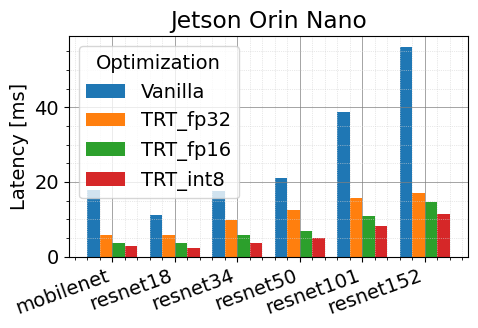

In [416]:
plot_network_latency(data_all)

## Throughput

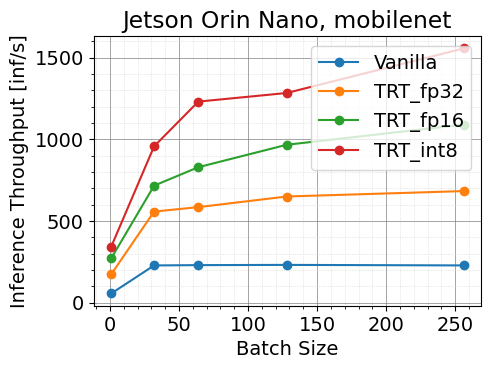

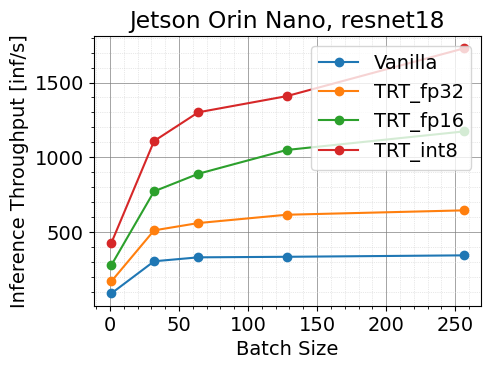

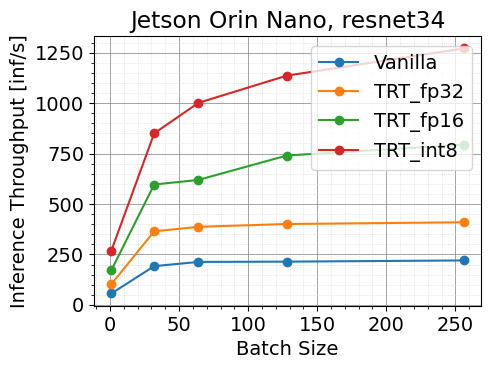

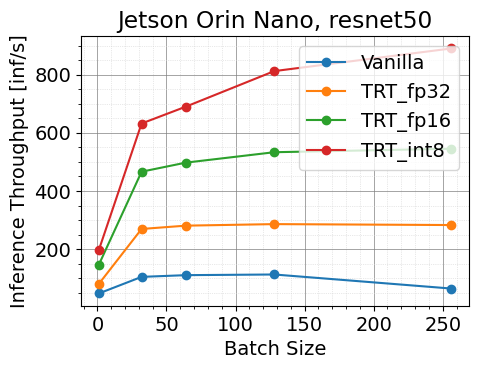

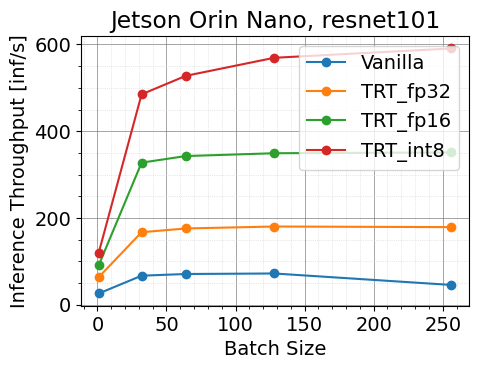

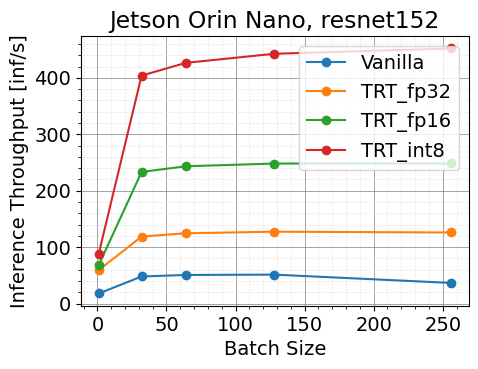

In [417]:

plot_network_throughput(data_throughput)